In [14]:
import pandas as pd
import datetime as dt
from IPython.display import display
from sklearn.impute import SimpleImputer

class DataPreprocessor:
    def __init__(self, filename):
        self.filename = filename
        self.df = pd.read_csv(self.filename)
    
    def drop_duplicates(self):
        remove_duplicates = input("Do you want to remove duplicates? Input T or F ") == "T"
        if remove_duplicates:
            self.df.drop_duplicates(inplace=True)
    
    def impute_missing(self, method='mean'):
        impute_values = input("Do you want to impute values? Input T or F ") == "T"
        if impute_values:
            impute_strategy = input("How do you want to impute your values? e.g. \"median\", \"0\" " )
            imputer = SimpleImputer()
            if impute_strategy.isdigit():
                imputer = SimpleImputer(strategy='constant', fill_value=int(impute_strategy))
            else:
                imputer = SimpleImputer(strategy = impute_strategy)
            self.df = pd.DataFrame(imputer.fit_transform(self.df), columns=self.df.columns)
            
    def display_table(self):
        display(self.df)
        to_csv = input("This is your new data file -- do you want to download it? Input T or F ") == "T"
        if to_csv:
            # Get the current timestamp
            timestamp = dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

            # Define the output filename
            # Split the filename into basename and extension
            basename, extension = os.path.splitext(self.filename)
            download_filename = f'{basename}_{timestamp}{extension}'

            # Download the dataframe to the output file
            self.df.to_csv(download_filename, index=False)
            
    def return_data(self):
        return self.df.iloc[:, :-1].values
        
    def return_labels(self):
        return self.df.iloc[:, -1].values


In [30]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, recall_score, precision_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

class Clustering:
    def __init__(self, data):
        self.model = None
        self.data = data
        self.pc_to_plot = 2
        
        #used to calculate different scores, if needed
        self.labels = None
    
    def f1_score(self, labels_true):
        return f1_score(labels_true, self.labels)
    
    def recall_score(self, labels_true):
        return recall_score(labels_true, self.labels)
    
    def precision_score(self, labels_true):
        return precision_score(labels_true, self.labels)
    
    def silhouette_score(self, data):
        return silhouette_score(data, self.labels)
    
    def cluster(self):
        raise NotImplementedError()
    
    def plot_clusters(self, model):
        # Fit PCA to the data
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.data)
        
        # Get the cluster labels and the number of clusters
        labels = self.labels
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Plot the data points colored by cluster
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
        plt.title(f'Clustering on PCA (Number of Clusters: {n_clusters})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        # Remove values on the x and y axes
        plt.tick_params(labelbottom=False, labelleft=False)
        
        #Show the plot
        plt.show()

class KMeansClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def elbow_method(self):
        # Calculate the within-cluster sum of squares (WCSS) for each k value
        wcss = []
        
        # Define range of k values to test
        k_values = range(1, 10)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(self.data)
            wcss.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, wcss, 'bx-')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method')

        # Determine the optimal number of clusters
        diffs = np.diff(wcss)
        diff_ratios = diffs[1:] / diffs[:-1]
        optimal_k = k_values[np.argmin(diff_ratios) + 1]

        # Display the optimal number of clusters
        plt.axvline(x=optimal_k, linestyle='--', color='r', label=f'Optimal k={optimal_k}')
        plt.legend()
        plt.show()

        print(f"Optimal number of clusters: {optimal_k}")
        
        return optimal_k
    
    def cluster(self, n_clusters=None):
        warnings.filterwarnings("ignore")
        if n_clusters is None:
            n_clusters = self.elbow_method()
        kmeans = KMeans(n_clusters=n_clusters)
        self.model = kmeans
        self.labels = kmeans.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)

class DBSCANClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, eps=None, min_samples=None):
        warnings.filterwarnings("ignore")
        if eps is None:
#             eps = np.sqrt(self.data.shape[1])
            eps=5000
        if min_samples is None:
            min_samples = 2 * self.data.shape[1]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.model = dbscan
        self.labels = dbscan.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.cluster import AgglomerativeClustering

class AgglomerativeClusteringAlgorithm(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    # The linkage parameter specifies the method used to compute the distance between clusters. 
    # It determines the way clusters are merged during the hierarchical clustering process.
    def cluster(self, n_clusters=2, linkage='ward'):
        self.model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        self.labels = model.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.cluster import MeanShift

class MeanShiftClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self):
        self.model = MeanShift()
        self.labels = self.model.fit_predict(self.data)
        self.centers = self.model.cluster_centers_
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.ensemble import IsolationForest

class IsolationForestClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)

    def cluster(self, contamination=None):
        if contamination is None:
            contamination = 0.05
        self.model = IsolationForest(contamination=contamination)
        self.model.fit(self.data)
        self.labels = self.model.predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.mixture import BayesianGaussianMixture

class BGMMClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, n_components=None):
        if n_components is None:
            n_components = 2
        self.model = BayesianGaussianMixture(n_components=n_components)
        self.model.fit(self.data)
        self.labels = self.model.predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        

In [16]:
from keras.layers import Input, Dense
from keras.models import Model

class AnomalyDetection:
    def __init__(self, data):
        self.data = data
        self.model = None
    
    def train(self):
        pass
    
    def detect(self, new_data):
        pass
    

class AutoEncoder(AnomalyDetection):
    def __init__(self, data, encoding_dim):
        super().__init__(data)
        self.encoding_dim = encoding_dim
        self.model = None
    
    def train(self):
        input_data = Input(shape=(self.data.shape[1],))
        #should these parameters be defined by the user?
        encoded = Dense(self.encoding_dim, activation='relu')(input_data)
        decoded = Dense(self.data.shape[1], activation='sigmoid')(encoded)
        self.model = Model(input_data, decoded)
        self.model.compile(optimizer='adam', loss='mse')
        self.model.fit(self.data, self.data, epochs=50, batch_size=32)
    
    def detect(self, new_data):
        reconstructions = self.model.predict(new_data)
        mse = np.mean(np.power(new_data - reconstructions, 2), axis=1)
        return mse
    
#maybe add GAN-based anomaly detection as mentioned in the paper "Explainable AI Approach for MOD Outliers in FAB to MOD Process"?

2023-04-07 15:47:23.901702: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 15:47:25.847584: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 15:47:25.852385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 15:47:36.384896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

class Classifier:

    def __init__(self):
        # clf stands for classifier
        self.clf = None

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        print(accuracy_score(y,y_pred))
        return accuracy_score(y, y_pred)

class DecisionTree(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = DecisionTreeClassifier(**kwargs)

class RandomForest(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = RandomForestClassifier(**kwargs)

class XGBoost(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = XGBClassifier(**kwargs)

class NeuralNetwork(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = MLPClassifier(**kwargs)

In [18]:
# Example usage
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Train a decision tree classifier
dt = DecisionTree()
dt.fit(X, y)
accuracy_dt = dt.score(X, y)

#Since classification is supervised, will try running on the mura_dataset after we obtain the labels

1.0


In [19]:
class Util:
    
    @staticmethod
    def getClusteringClass(user_input_clustering_algorithm, data):
        # create a dictionary that maps user input to the corresponding class
        clustering_class_dict = {
            "kmeans": KMeansClustering(data),
            "dbscan": DBSCANClustering(data),
            "agglomerative": AgglomerativeClusteringAlgorithm(data),
            "meanshift": MeanShiftClustering(data),
            "isolation forest": IsolationForestClustering(data),
            "bgmm": BGMMClustering(data)
        }

        return clustering_class_dict[user_input_clustering_algorithm]
    
class App:
    def __init__(self, filename):
        self.preprocessor = DataPreprocessor(filename)
        self.clustering = None
        
    def start(self):
        
        # Ask the user for preprocessing options
        self.preprocessor.drop_duplicates()
        self.preprocessor.impute_missing()

        # Show the user how the new table looks, and ask the user if he/she wants to download it
        self.preprocessor.display_table()

        data = self.preprocessor.return_data()

        # Ask the user for clustering options
        clustering_algorithm = input("""Which clustering algorithm do you wish to use? We currently support the following:
                                        kmeans, dbscan, meanshift, agglomerative, isolation forest, bgmm """)
        
        self.clustering = Util.getClusteringClass(clustering_algorithm, data)

        # Perform clustering
        self.clustering.cluster()
        
        # Measure performance
        silhouette_score = self.clustering.silhouette_score(data)

        # Print the score
        print("Silhouette score:", silhouette_score)


Do you want to remove duplicates? Input T or F T
Do you want to impute values? Input T or F T
How do you want to impute your values? e.g. "median", "0" mean


,Unnamed: 0,bright_sum,bright_size,bright_density,dark_sum,dark_size,dark_density
0,0.0,2200.0,21.0,104.761905,0.0,0.0,137.861505
1,1.0,5411.0,48.0,112.729167,0.0,0.0,137.861505
2,2.0,4041.0,37.0,109.216216,0.0,0.0,137.861505
3,3.0,16782.0,149.0,112.630872,0.0,0.0,137.861505
4,4.0,31296.0,267.0,117.213483,0.0,0.0,137.861505
...,...,...,...,...,...,...,...
1934,1934.0,0.0,0.0,116.969190,46759.0,368.0,127.062500
1935,1935.0,0.0,0.0,116.969190,26529.0,203.0,130.684729
1936,1936.0,2692.0,25.0,107.680000,120569.0,957.0,125.986416
1937,1937.0,4334.0,41.0,105.707317,84513.0,643.0,131.435459


This is your new data file -- do you want to download it? Input T or F F
Which clustering algorithm do you wish to use? We currently support the following:
                                        kmeans, dbscan, meanshift, agglomerative, isolation forest, bgmm isolation forest


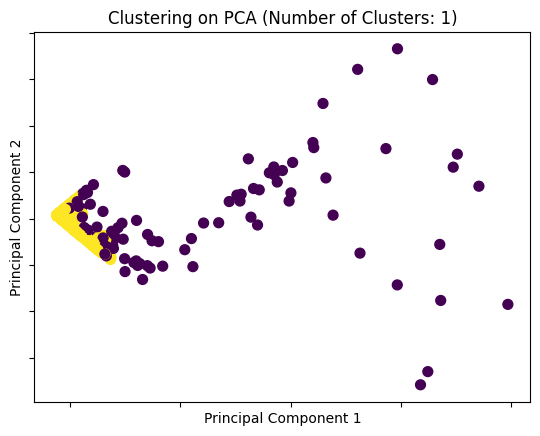

Silhouette score: 0.8520689471262108


In [32]:
app = App("mura_data.csv")
app.start()